# Generamos train y test sets

Importamos las librerías necesarias.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

Definimos algunas funciones auxiliares.

In [ ]:
def generar_grilla(sqrt_n):
    xx = np.linspace(1,sqrt_n,sqrt_n)
    X, Y = np.meshgrid(xx,xx)
    return np.column_stack((X.flatten(), Y.flatten())) #Ordenados de izq a der y de abajo hacia arriba

P = lambda alpha: np.array([[np.cos(alpha), np.sin(alpha)],[-np.sin(alpha), np.cos(alpha)]])
D = lambda ratio: np.diag([1,ratio])
A = lambda alpha, ratio: P(alpha) @ D(ratio) @ P(alpha).T

matern_model = lambda t, x: (1 + x/t) * np.exp(-x/t) # nu=3/2

def cholesky(alpha, t, ratio, H):
    sqrt_H_TAH = np.sqrt(np.einsum('ijk,ijk->ij', H @ A(alpha, ratio) , H))
    sigma = matern_model(t, sqrt_H_TAH)
    return np.linalg.cholesky(sigma)

def simular_cholesky(L):
    Z = L @ np.random.normal(0,1,256)
    return np.flipud(Z.reshape(16,16))

def plot_ejemplo(Z, title = 'Campo aleatorio Matérn'):
    sqrt_n = int(np.sqrt(Z.size))
    plt.imshow(Z, cmap = 'viridis',
               extent = [1,sqrt_n,1,sqrt_n])
    plt.colorbar(); plt.title(title); plt.show()

# H = points[:, np.newaxis, :] - points[np.newaxis, :, :]

## Grilla de parámetros

El parámetro $\alpha$ representa el ángulo entre el eje 'x' y el eje principal de la elipse que define la anisotropía geométrica, estos valores representan direcciones.

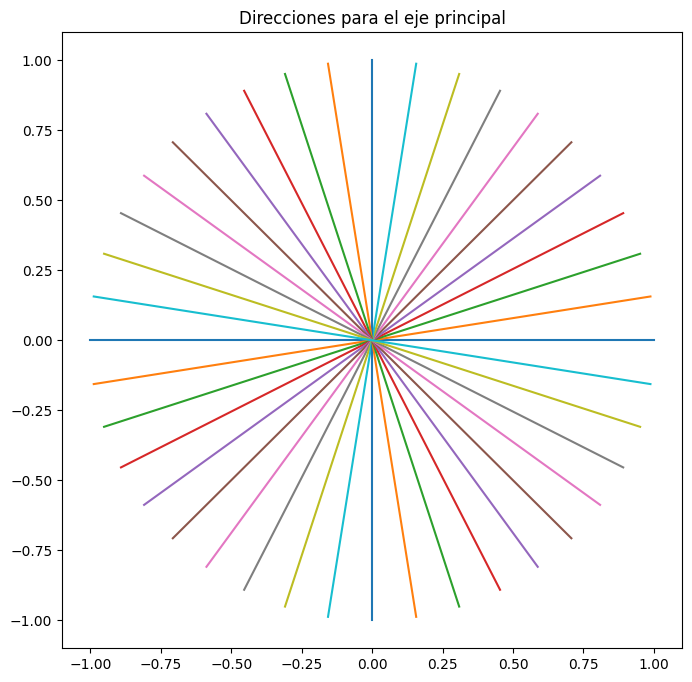

In [ ]:
alphas = np.deg2rad(np.linspace(0,180,20,endpoint=False)) # np.deg2rad([0,45,90,135])
plt.figure(figsize=(8,8))
for alpha in alphas:
    plt.plot([np.cos(alpha), -np.cos(alpha)], [np.sin(alpha), -np.sin(alpha)])
plt.title('Direcciones para el eje principal');

El parámetro $\theta$ controla el rango práctico, observemos las funciones de covarianza para algunos valores del parámetro.

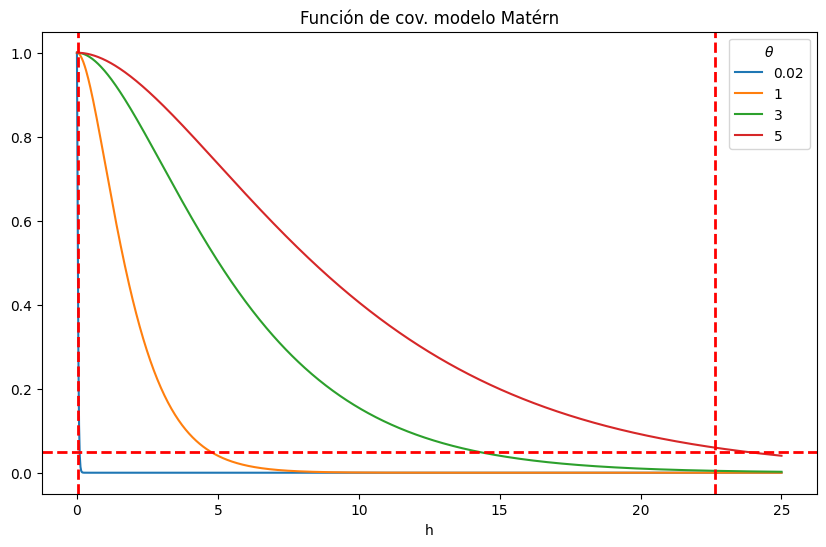

In [ ]:
hs = np.linspace(0, 25, 1_000)
thetas = [0.02, 1, 3, 5]

plt.figure(figsize=(10,6))
for theta in thetas:
    plt.plot(hs, matern_model(theta, hs), label=f'{theta}')

plt.axhline(0.05, ls='--', lw=2, c='r')
plt.axvline(0.05, ls='--', lw=2, c='r')
plt.axvline(16*np.sqrt(2), ls='--', lw=2, c='r')
plt.legend(title=r'$\theta$')
plt.title('Función de cov. modelo Matérn')
plt.xlabel('h');

En base al gráfico anterior, para generar el conjunto de entrenamiento, creamos una grilla de 150 valores de $\theta$ en el intervalo $[0.02, 5]$, concentrando los puntos en la zona media $[1,3]$.

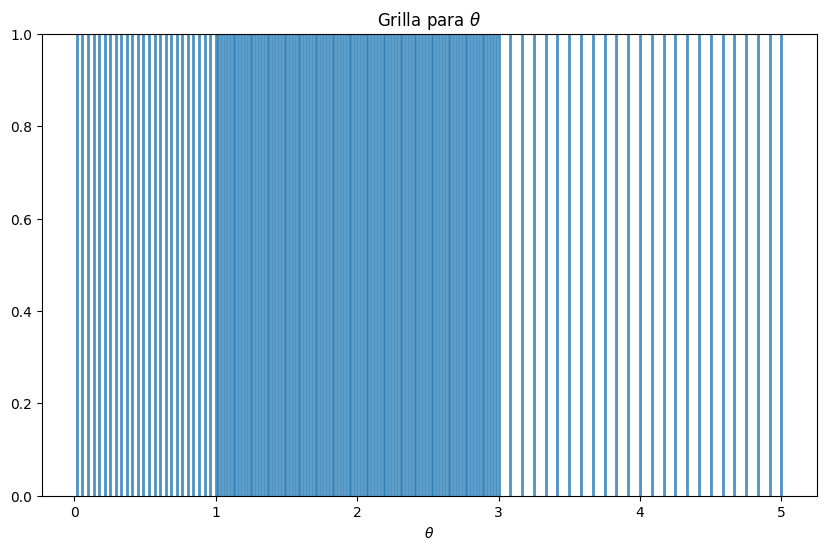

In [ ]:
thetas = np.concatenate([
    np.linspace(0.02, 1, 25, endpoint=False),
    np.linspace(1, 3, 100, endpoint=False),
    np.linspace(3, 5, 25)
])

plt.figure(figsize=(10,6))
for i in thetas:
    plt.axvline(i, lw=2, alpha=0.8)
plt.title(r'Grilla para $\theta$')
plt.xlabel(r'$\theta$');

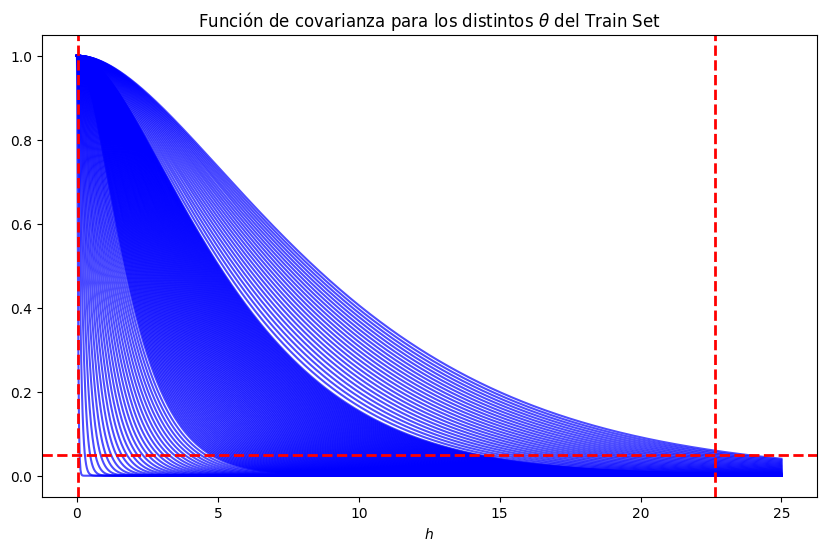

In [ ]:
plt.figure(figsize=(10,6))
for theta in thetas:
    plt.plot(hs, matern_model(theta, hs), c='b', alpha=0.7)

plt.axhline(0.05, ls='--', lw=2, c='r')
plt.axvline(0.05, ls='--', lw=2, c='r')
plt.axvline(16*np.sqrt(2), ls='--', lw=2, c='r')
plt.title(r'Función de covarianza para los distintos $\theta$ del Train Set')
plt.xlabel(r'$h$');

Por otro lado, como $\text{ratio}=\frac{\text{eje menor}}{\text{eje mayor}}$ utilizaremos una grilla de 150 puntos entre 0 y 1 para el ratio, sin considerar los extremos y concentrando los puntos en el subintervalo $[0.3, 0.7]$.

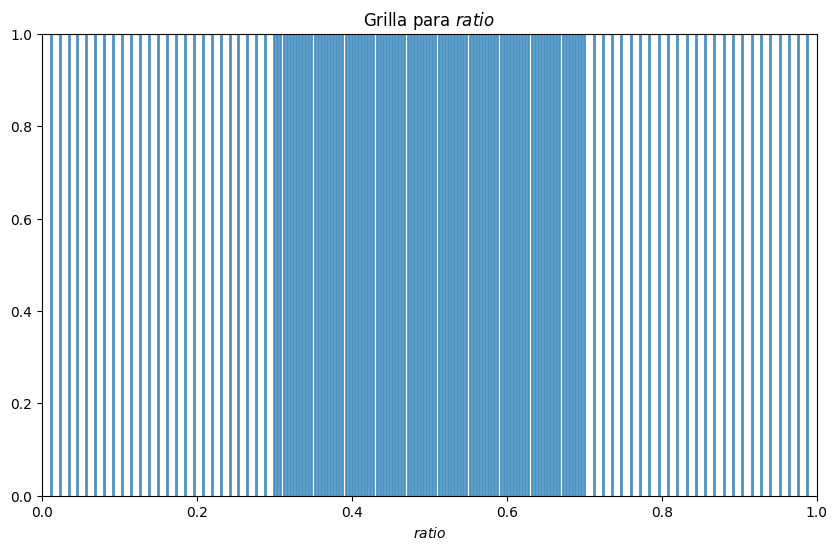

In [ ]:
ratios = np.concatenate([
    np.linspace(0, 0.3, 26, endpoint=False)[1:],
    np.linspace(0.3, 0.7, 100, endpoint=False),
    np.linspace(0.7, 1, 25, endpoint=False)
])

plt.figure(figsize=(10,6))
for i in ratios:
    plt.axvline(i, lw=2, alpha=0.8)
plt.title(r'Grilla para $ratio$')
plt.xlabel(r'$ratio$');

Por lo tanto, obtendremos la siguiente cantidad de configuraciones de parámetros.

In [ ]:
alphas.size * thetas.size * ratios.size

450000

A continuación se gráfican algunas de las elipses del Train Set que representan la anisotropía geométrica.

In [ ]:
Zs = np.random.normal(0,1,(2_000,2))
Zs = Zs / np.linalg.norm(Zs, axis = 1, keepdims = True)

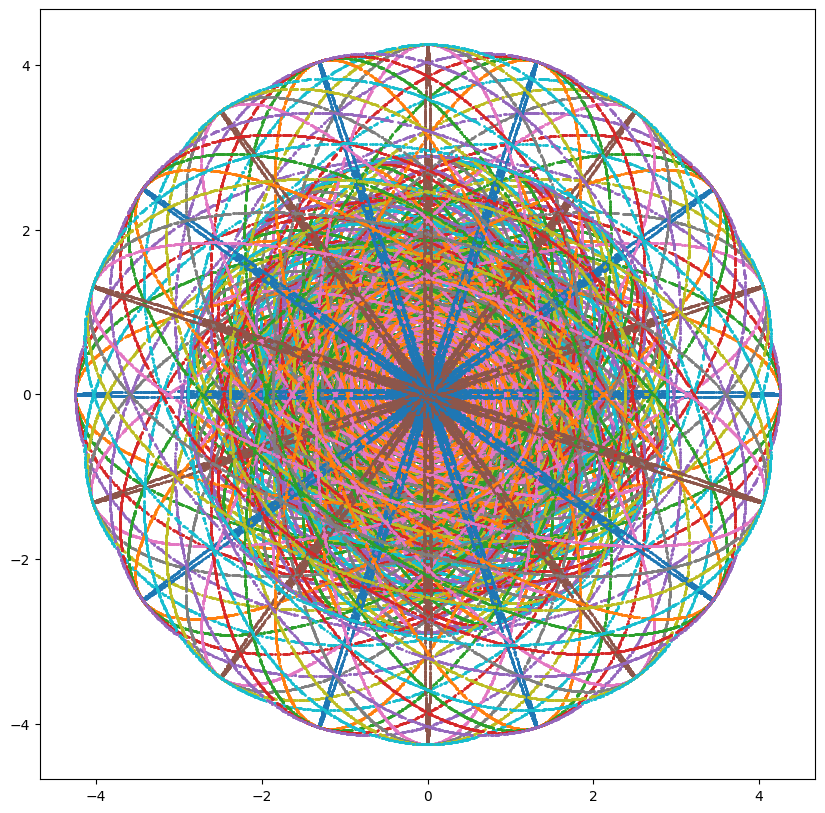

In [ ]:
plt.figure(figsize=(10,10))
for theta in thetas[::20]:
    for alpha in alphas[::2]:
        for ratio in ratios[::30]:
            elipse = theta * Zs @ D(ratio) @ P(alpha)
            plt.scatter(elipse[:,0], elipse[:,1], s=1)

Las simulaciones y configuraciones de parámetros serán guardados en archivos .npy

Es por esto que nos conectamos con el drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = "..."

## Train Set

In [ ]:
X_train = []
y_train = []

sqrt_n = 16
points = generar_grilla(sqrt_n)
H = points[:, np.newaxis, :] - points[np.newaxis, :, :]

In [ ]:
%%time
for alpha in alphas:
    for theta in thetas:
        for ratio in ratios:
            X_train.append(simular_cholesky(cholesky(alpha, theta, ratio, H)))
            y_train.append([alpha, theta, ratio])

CPU times: user 32min 48s, sys: 25min 40s, total: 58min 29s
Wall time: 36min 6s


In [ ]:
%%time
for name, conj in zip(['X_train', 'y_train'], [X_train, y_train]):
    np.save(
        path + f'{name}.npy',
        np.array(conj, dtype=np.float32)
    )

CPU times: user 1.12 s, sys: 378 ms, total: 1.5 s
Wall time: 7.16 s


In [ ]:
len(X_train)

450000

## Test set

Para generar el conjunto de prueba, consideraremos todos los ángulos para cubrir todas las direcciones entrenadas. Por otro lado, consideraremos ~30 valores para cada parámetro $\theta, \text{ratio}$ en la parte densa de la grilla. Para cada combinación de parámetros, simularemos 5 campos aleatorios.

In [ ]:
X_train, y_train = None, None

X_test = []
y_test = []

Será la siguiente cantidad de configuraciones de parámetros para el conjunto de prueba:

In [ ]:
thetas_test = np.linspace(1, 3, 100, endpoint=False)[::3]

In [ ]:
ratios_test = np.linspace(0.3, 0.7, 100, endpoint=False)[::3]

In [ ]:
alphas.size * thetas_test.size * ratios_test.size

23120

In [ ]:
%%time
for alpha in alphas:
    for theta in thetas_test:
        for ratio in ratios_test:
            for _ in range(5):
                X_test.append(simular_cholesky(cholesky(alpha, theta, ratio, H)))
                y_test.append([alpha, theta, ratio])

CPU times: user 8min 18s, sys: 6min 26s, total: 14min 44s
Wall time: 9min


In [ ]:
%%time
for name, conj in zip(['X_test', 'y_test'], [X_test, y_test]):
    np.save(
        path + f'{name}.npy',
        np.array(conj, dtype=np.float32)
    )

CPU times: user 265 ms, sys: 136 ms, total: 401 ms
Wall time: 475 ms


In [ ]:
len(y_test)

115600